# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.


--- 

## 0. Managing dependencies

As this report shares mostly of the dependencies as the "root" repository forked from Udacity Deep Reinforcement learning, the instruction for handling dependencies are the same as stated at README.md. Please refer to the README at the root of this repository for the original file from which the below section was extracted.

### Dependencies

To set up your python environment to run the code in this repository, follow the instructions below.

1. Create (and activate) a new environment with Python 3.6.

	- __Linux__ or __Mac__: 
	```bash
	conda create --name drlnd python=3.6
	source activate drlnd
	```
	- __Windows__: 
	```bash
	conda create --name drlnd python=3.6 
	activate drlnd
	```
	
2. Follow the instructions in [this repository](https://github.com/openai/gym) to perform a minimal install of OpenAI gym.  
	- Next, install the **classic control** environment group by following the instructions [here](https://github.com/openai/gym#classic-control).
	- Then, install the **box2d** environment group by following the instructions [here](https://github.com/openai/gym#box2d).
	
3. Clone the repository (if you haven't already!), and navigate to the `python/` folder.  Then, install several dependencies.
```bash
git clone https://github.com/udacity/deep-reinforcement-learning.git
cd deep-reinforcement-learning/python
pip install .
```

4. Create an [IPython kernel](http://ipython.readthedocs.io/en/stable/install/kernel_install.html) for the `drlnd` environment.  
```bash
python -m ipykernel install --user --name drlnd --display-name "drlnd"
```

5. Before running code in a notebook, change the kernel to match the `drlnd` environment by using the drop-down `Kernel` menu. 

6. As an final step we need to use the Udacity Reacher environment: They are available in the following versions:

    [One agent with visualization](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Linux.zip)

    [One agent no visualization](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Linux_NoVis.zip)

    [Multi agent with visualization](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux.zip)

    [Multi agent no visualization](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux_NoVis.zip)

    Just download the correction version and set the variables **MULTI_AGENT** and **VIS_ENABLED** according to the desired version.
    
    
7. As an additional step some dependencies will be handled by using the next cell.

8. For running locally with NVIDIA GPU and CUDA, it is necessary to download the correct PyTorch version. Please refer to the instructions at this [link](https://pytorch.org/get-started/locally/).



In [14]:
!pip -q install ../python

## 1. Start the Environment
We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [15]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

## 2. Configuration

The cell below act as an abstraction for using one of the many environment variants of the workspace. If the variable **'MULTI_AGENT'** is set by the user, this workspace will understand that we would like to solve the problem using the Unity simulator with 20 reacher arms, otherwise, the single reacher arm would be used. 

By enabling the visualization, through the **'VIS_ENABLED'**, the GUI of the simulator can be turned on or off.


**NOTE**: Bellow we hardcode the location of the files for the reacher environment. Feel free to adapt it as needed in order to make this notebook run with the desired variant of the problem.

In [ ]:
MULTI_AGENT = True
VIS_ENABLED = False

if 'MULTI_AGENT' in globals() and MULTI_AGENT:
    if 'VIS_ENABLED' in globals() and VIS_ENABLED:
        env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')
    else:
        env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')
        
        
else:
    if 'VIS_ENABLED' in globals() and VIS_ENABLED:
        env = UnityEnvironment(file_name='./Reacher_One_Linux/Reacher_One_Linux_NoVis.x86_64')
    else:
        env = UnityEnvironment(file_name='./Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
        
        
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print( env.brain_names )

In [ ]:
print( env.brain_names )

In [28]:
from collections import deque
import torch

## 3. Agent Setup

Below we can configure all the necessary parameters that are relevant for the agent training behaviour. 

| Parameter             |Description                                                                                       |
|-----------------------|--------------------------------------------------------------------------------------------------|
| state size            | Size of the state the is observed from the agent                                                 |
| action size           | Size of the state the agent uses to interact with the environment                                |
| random_seed           | Seed used for internally generate random variables                                               |
| buffer_size           | Maximum number of entries for the replay buffer                                                  |
| batch_size            | How many replay buffer entires will be used for each learning                                    |
| gamma                 | Discount factor                                                                                  |
| tau                   | Smooth factor used for uptading the local networks parameters from target network parameters     |
| lr_actor              | Learning rate for the actor Network                                                              |
| lr_critic             | Learning rate for the critic network                                                             |
| actor_weight_decay    | L2 Weight regularizer for the actor netowrk                                                      |
| critic_weight_decay   | L2 Weight regularizer for the critic network                                                     |   
| learn_prescaler       | How many steps the agent should run between each learning                                        |
| learning_cycles       | How many many times the agent should run the backprop. proccess after **learn_prescaler** cycles |
| noise_initial_gain    | The initial gain applied for the noise added to the network output.                              |
| noise_gain_decay      | Factor to multiply **noise_initial_gain** for each step. Makes the noise gain decay as the proccess goes. Keep it 1.0 to disable this behaviour |
| sample_every_cycle    | For each **learning_cycles**, if the agent should sample from the replay buffer. If false, the agent will try to run the backprop **learning_cycles** in a row using the same initial sample.                                    |
| gradient_limiter      | If the agent should, or should not, limit the gradient for gradient ascent step                   |


In [ ]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
# number of agents
num_agents = len(env_info.agents)

In [ ]:
%load_ext autoreload
%autoreload 2
from ddpg_agent import Agent

agent = Agent(state_size          = 33, 
              action_size         = 4, 
              random_seed         = 2, 
              buffer_size         = 100000,
              batch_size          = 128,
              gamma               = 0.99,
              tau                 = 1e-3,
              lr_actor            = 2e-4,
              lr_critic           = 2e-4,
              actor_weight_decay  = 0,
              critic_weight_decay = 0,
              learn_prescaler     = 20, 
              learning_cycles     = 10, 
              noise_initial_gain  = 1.0,
              noise_gain_decay    = 1.0,
              sample_every_cycle  = True, 
              gradient_limiter    = True)

## 3. Agent Network representation

In order to expose the network architecture choosen for the project, we implemented the method __repr__() into the ddpg_agent class that print both networks.

In [47]:
print( agent )

Actor(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Critic(
  (fcs1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## 4. Learning proccess

The method "ddpg", described below, controls the learning algorithm that the agent will perform. As the parameters for this method:

| Parameter | Description |
|-----------|-------------|
|n_episodes | This defines the maximum number of episodes that will be run in order to train the agent
|max_t      | When running the simulation, this value address how many iterations the simulation should run before be terminated|
|print_every| This controls the size of the deque used in order to smooth out the output and also when to print an output informing the training performance |

### Description

As a brief description for the learning proccess, at the beginning of each episode the environment is reseted in order to place all agents in a given initial state. 

Then, for **max_t** iterations the simulation will run and the follow steps are performed:

**1.** The environment states are used in order to infer the actions using the local Actor network at the agent.

**2.** The actions are passed down to the environment in order to update what each agent should perform given it's present state. One important note is the that the "act" function countains a "implicit" parameter, **add_noise**, that by default add an random value to the network output. This will allow the agent to explore the environment and add new values to the replay buffer that would not be achieve otherwise.

**3.** After updating the simulation the current state, action, next state, rewards and if the agent achieved the desired goal are inserted into the replay buffer. Note that for the multi-agent environment this will be done for each "tuple" for these variables. 

**4.** Finally, the agent **step** method will perform the hard work of adding up this tuple to the replay buffer and at each **learn_prescaler** samples to perform **learning_cycles** back propagation cycles to the network. As stated above if **sample_every_cycle** is True, each backpropagation will update the "target" version of the Actor and Critic networks using **batch_size** samples from the replay buffer sampled for each cycle. 

One important parameter for this step is **tau**, which will smooth out the Target network parameters before applying for the actor and critic network. This proccess is important to make the larning more stable as the most recent result of the gradient ascent will be only contribute to the "local" parameters of the networks



/home/bmendonca/workspace/udacity/deep-reinforcement-learning/p2_continuous-control/ddpg_agent.py:170: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 32.25
Episode 200	Average Score: 33.35
Episode 250	Average Score: 34.23

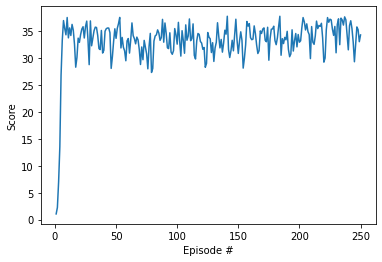

In [6]:
def ddpg(n_episodes=250, max_t=10000, print_every=100):   
    scores_deque = deque(maxlen=print_every)
    scores = []

    
    for i_episode in range(1, n_episodes+1):
        
        states = env.reset(train_mode=True)[brain_name].vector_observations     # reset the environment    
        agent.reset()
        
        scores_episode = np.zeros(num_agents)               # rewards per episode for each agent
        
        for t in range( max_t ):
            actions     = agent.act(states)
            env_info    = env.step(actions)[brain_name]     # send all actions to tne environment
            next_states = env_info.vector_observations      # get next state (for each agent)
            rewards     = env_info.rewards                  # get reward (for each agent)
            dones       = env_info.local_done               # see if episode finished
            
            for (state, action, reward, next_state, done) in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            
            states = next_states
            scores_episode += rewards
            
            if any(dones):
                break 
                
        
        #Averaring the mean score across all agents for this episode
        mean_score = np.mean( scores_episode )

        scores.append( mean_score )
        scores_deque.append( mean_score )
        
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean( scores_deque )), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean( scores_deque )))
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions     = agent.act(states)                    # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 36.87799917571247


In [8]:
env.close()

## Future improvements

In order to acheve better training stability, or even to understand how other algorithms works, some points that i would like to test in the future are:

### Testing A2C and A3C

As was stated in the classes some researchers may not consider DDPG, used for this solution, as an "Actor-Critic" in the strict form and, for knowledge, i would like to understand how would be the performance of the Multi-agent DDPG compared to A2C ad A3C methods. 

### Hyperparemeters Episode-based scaling.

As far as i understood adding the random components to the network output allows it to "explore" and to diversify it's output and make the Critic more aware of different scenarios which will, eventually, lead to a better exploration of the "state-space".

As the network progresses training, and this could be evaluated using episodes or even it's score, maybe it would make sense to reduce the noise magnitude added to make it smaller as the training progresses. My suggestion that needs to be proven by data and testing is that this could lead to faster convergenge or, at least, better reaching the network local-máxima, increase it's score.